In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/shopping-mall-customer-data-segmentation-analysis/Shopping Mall Customer Segmentation Data .csv
/kaggle/input/shopping-mall-customer-data-segmentation-analysis/Group Report Summary(Graduate School Work).docx
/kaggle/input/shopping-mall-customer-data-segmentation-analysis/cleaned_shoppingdata.sqlite
/kaggle/input/shopping-mall-customer-data-segmentation-analysis/Presentation Demo.pdf
/kaggle/input/shopping-mall-customer-data-segmentation-analysis/ShoppingMall-Data Cleaning-Segmentaiton-Visualization.ipynb


# Unsupervised Learning Project

I will look at customer spending data in a mall and try and get insights for mall owners on how they can plan their marketting strategy for increasing customer spend in their shops.

### High level approach
Using PCA and k-means, I will segment customers based on their spending data. By analyzing the characteristics of these clusters, I aim to provide data-driven recommendations for marketing strategies that can target specific customer groups, such as motivating low-spending customers to increase their spending

## Step 1: Reading data

In [2]:
import numpy as np
import pandas as pd
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from math import sqrt

In [3]:
url = "/kaggle/input/shopping-mall-customer-data-segmentation-analysis/Shopping Mall Customer Segmentation Data .csv"
df = pd.read_csv(url)
df.head()

,Customer ID,Age,Gender,Annual Income,Spending Score
0,d410ea53-6661-42a9-ad3a-f554b05fd2a7,30,Male,151479,89
1,1770b26f-493f-46b6-837f-4237fb5a314e,58,Female,185088,95
2,e81aa8eb-1767-4b77-87ce-1620dc732c5e,62,Female,70912,76
3,9795712a-ad19-47bf-8886-4f997d6046e3,23,Male,55460,57
4,64139426-2226-4cd6-bf09-91bce4b4db5e,24,Male,153752,76


## Step 2: EDA

In this step we will perform the following
1. Cleanup data as per our needs.
2. Handle with missing / null data.
3. Visualize data.
4. Scale data as needed

Lets first get some basic understanding of data.

In [4]:
print ('Data shape', df.shape)
print ('===========================')
print ('Data info')
print(df.info())
print ('===========================')
print ('Null items in data', df.isnull().sum())
print ('===========================')
print ('Data duplicates', df.duplicated().sum())
print ('===========================')
print ('Statistical analysis of data')
print (df.describe())

Data shape (15079, 5)
Data info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15079 entries, 0 to 15078
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Customer ID     15079 non-null  object
 1   Age             15079 non-null  int64 
 2   Gender          15079 non-null  object
 3   Annual Income   15079 non-null  int64 
 4   Spending Score  15079 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 589.1+ KB
None
Null items in data Customer ID       0
Age               0
Gender            0
Annual Income     0
Spending Score    0
dtype: int64
Data duplicates 0
Statistical analysis of data
                Age  Annual Income  Spending Score
count  15079.000000   15079.000000    15079.000000
mean      54.191591  109742.880562       50.591617
std       21.119207   52249.425866       28.726977
min       18.000000   20022.000000        1.000000
25%       36.000000   64141.000000       26.000000
50%       

Okay so putting it in plain English on what I see.
1. There are 15,079 datapoints/rows in the dataset.
2. Each row in the dataset has following data - Customer ID, Age, Gender, Annual Income, Spending Score. Few things to note, A) Gender which is rendered as object (ie string), whereas we know it is a categorical attribute, so I need to modify it to categorical data. B) We do not need Customer ID for any form of analysis as it is a unique identifier for every customer. I will drop it going forward.
4. There are no null values.
5. There are no duplicates.
6. From the statistical analysis, I see that there is wide range between different attributes. e.g. Age varies between 54 and 90 (\~40 delta) whereas Income varies between \~20k and \~200k (\~180k delta). I would be required to scale these to a common scale. Why this is important is because I would be using PCA and PCA would provide lot more importance to attribute which has more variance (e.g. Income) and attributes / features which have low variance would be thought to be insignificant.

In [5]:
df = df.drop('Customer ID', axis=1)

In [6]:
df['Gender'] = df['Gender'].astype('category')
print ('df types', df.dtypes)
df.head()

df types Age                  int64
Gender            category
Annual Income        int64
Spending Score       int64
dtype: object


,Age,Gender,Annual Income,Spending Score
0,30,Male,151479,89
1,58,Female,185088,95
2,62,Female,70912,76
3,23,Male,55460,57
4,24,Male,153752,76


In [7]:
df.columns

Index(['Age', 'Gender', 'Annual Income', 'Spending Score'], dtype='object')

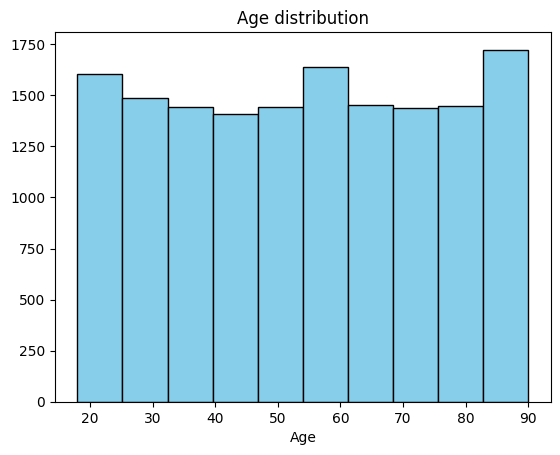

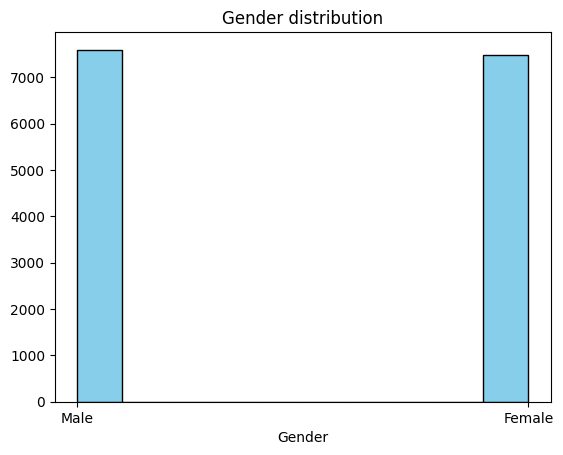

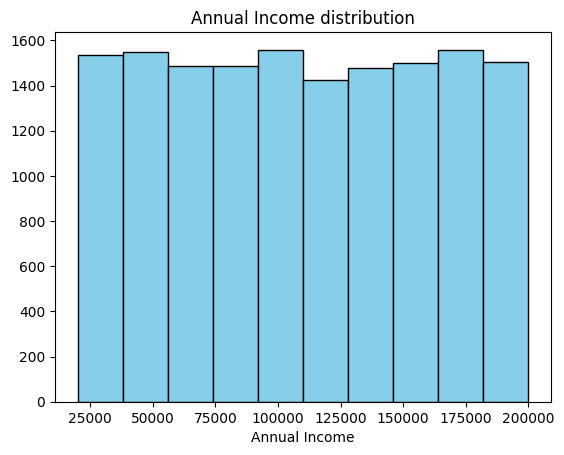

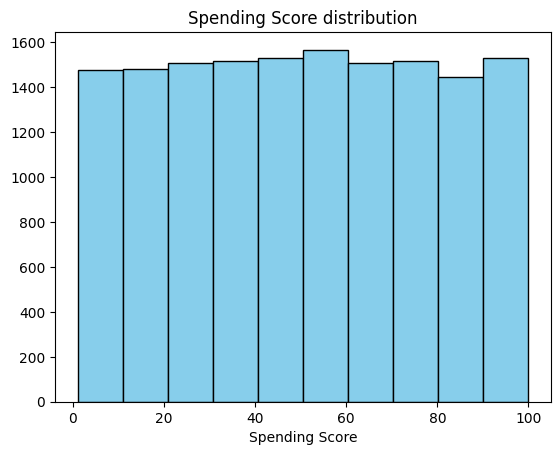

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


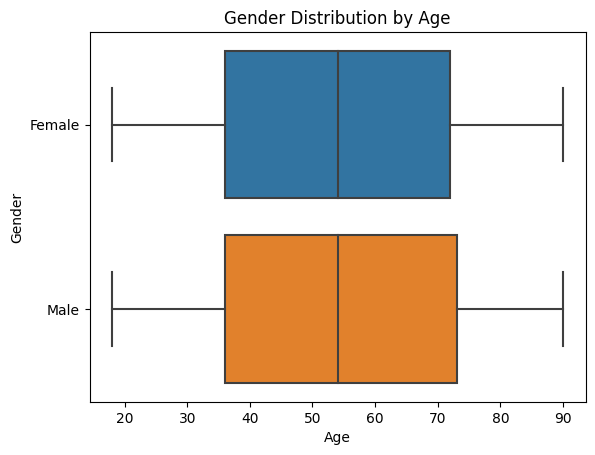

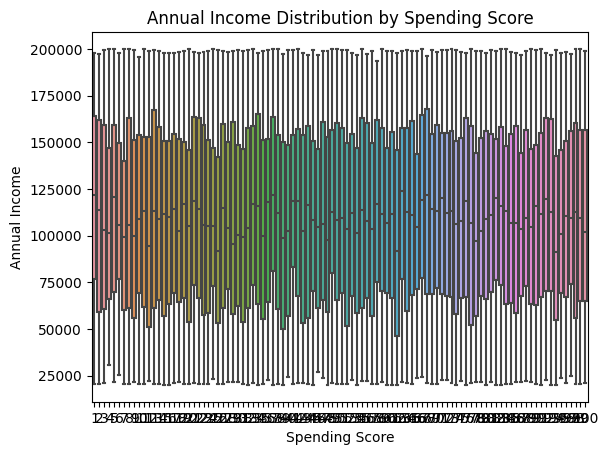

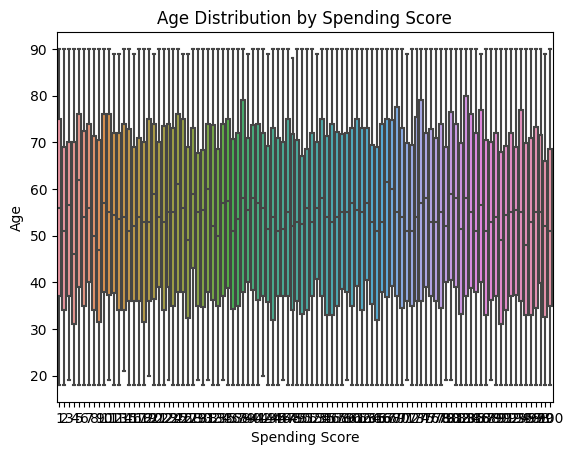

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


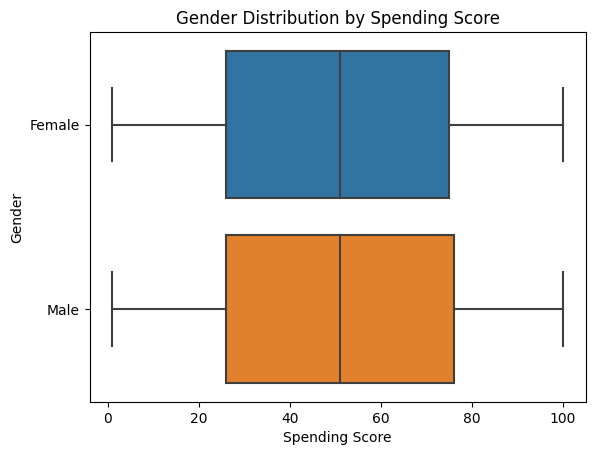

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


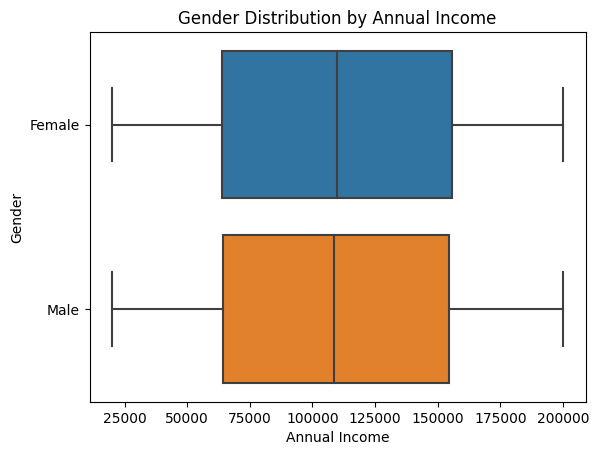

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_bin_10(column):
    # Histogram
    plt.hist(df[column], bins=10, color='skyblue', edgecolor='black')
    plt.xlabel(column)
    plt.title(column + ' distribution')
    plt.show()

def plot_box_graph(column1, column2):
    sns.boxplot(x=column1, y=column2, data=df)
    plt.title(column2 + ' Distribution by ' + column1)
    plt.show()

for column in df.columns:
    plot_bin_10(column)

plot_box_graph('Age', 'Gender')
# plot_box_graph('Annual Income', 'Age')
plot_box_graph('Spending Score', 'Annual Income')
plot_box_graph('Spending Score', 'Age')
plot_box_graph('Spending Score', 'Gender')
plot_box_graph('Annual Income', 'Gender')

Observations:
* Data looks evenly distributed which is good. There is little to no skewness in data.
* `Gender` is evenly distributes w.r.t. other attributes.

In [9]:
from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
df_string = df[['Annual Income', 'Spending Score', 'Age']]
print(df_string.head())

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_string)
df_standardized = pd.DataFrame(scaled_data, columns=['Annual Income', 'Spending Score', 'Age'])

df_standardized.head()

   Annual Income  Spending Score  Age
0         151479              89   30
1         185088              95   58
2          70912              76   62
3          55460              57   23
4         153752              76   24


,Annual Income,Spending Score,Age
0,0.798813,1.337059,-1.145516
1,1.442076,1.545929,0.180335
2,-0.743208,0.884507,0.369742
3,-1.038953,0.223086,-1.476979
4,0.842317,0.884507,-1.429627


In [10]:
# Lets join this with the remaining (Gender) column(s)
from sklearn.preprocessing import LabelEncoder
# Convert 'Gender' column to numerical values (0 for Female, 1 for Male)
df_standardized['Gender'] = LabelEncoder().fit_transform(df['Gender'])

df_standardized.head()

,Annual Income,Spending Score,Age,Gender
0,0.798813,1.337059,-1.145516,1
1,1.442076,1.545929,0.180335,0
2,-0.743208,0.884507,0.369742,0
3,-1.038953,0.223086,-1.476979,1
4,0.842317,0.884507,-1.429627,1


In [11]:
pd.options.display.float_format = '{:.6f}'.format

df_standardized.describe()

,Annual Income,Spending Score,Age,Gender
count,15079.000000,15079.000000,15079.000000,15079.000000
mean,-0.000000,-0.000000,-0.000000,0.503681
std,1.000033,1.000033,1.000033,0.500003
min,-1.717222,-1.726365,-1.713738,0.000000
25%,-0.872802,-0.856075,-0.861405,0.000000
50%,-0.010582,0.014216,-0.009072,1.000000
75%,0.866356,0.849696,0.843261,1.000000
max,1.726988,1.719987,1.695594,1.000000


As we can see the range of all the columns have been moved between -1.7 to 1.7. The actual numbers dont matter much, what matters is all columns have been scaled to common scale.

## Step 3: Apply PCA
Now I will apply PCA to reduce dimensionality by identifying components that capture the most variance in the data. This will help focus on the most significant patterns while ignoring less relevant variations

In [13]:
from sklearn.decomposition import PCA

pca_full = PCA()
pca_full.fit(df_standardized)
cumulative_variance = pca_full.explained_variance_ratio_.cumsum()
print("Cumulative Variance Explained:", cumulative_variance)

Cumulative Variance Explained: [0.31028984 0.61881789 0.92308681 1.        ]


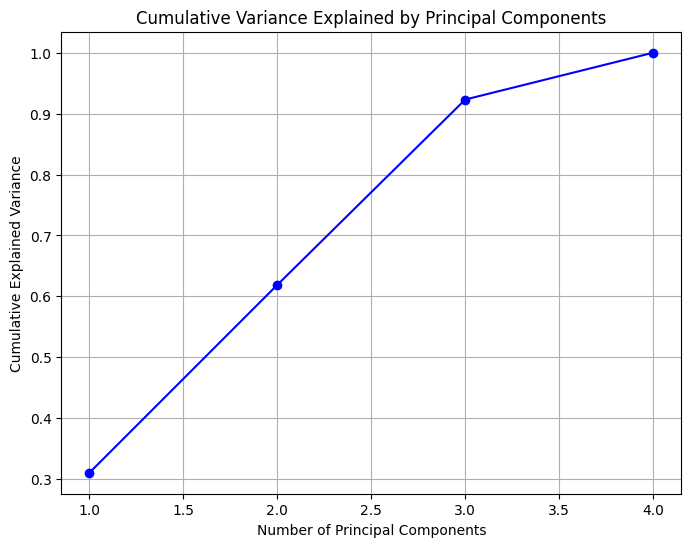

In [14]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-', color='b')
plt.title('Cumulative Variance Explained by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

Since 92% of the variance is captured by the first three components, I will reduce the dimensionality of the dataset by using only the first 3 principal components instead of the entire original set of features. This allows for easier visualization and faster processing while still retaining most of the important information.

In [15]:
from sklearn.decomposition import PCA

# Step 1: Apply PCA to the standardized data, keeping 3 components
pca = PCA(n_components=3)
df_pca = pca.fit_transform(df_standardized)

# Step 2: Create a new DataFrame with the 3 principal components
df_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2', 'PC3'])

# View the new DataFrame with the first 3 principal components
print(df_pca.head())


        PC1       PC2       PC3
0 -1.590430  1.062728  0.286174
1 -0.643978  1.980028 -0.403111
2 -0.430627 -0.186858 -1.115781
3 -1.405571 -1.103024  0.345548
4 -1.494918  0.844712  0.766543


In [16]:
# Get the PCA components (loadings) for each principal component
loadings = pca.components_

# Create a DataFrame to display the loadings for each principal component
loadings_df = pd.DataFrame(loadings, columns=df_standardized.columns, index=['PC1', 'PC2', 'PC3'])

# Display the loadings for each component
print(loadings_df)


     Annual Income  Spending Score       Age    Gender
PC1       0.164984       -0.657006  0.735607 -0.002247
PC2       0.875113        0.441524  0.198075  0.000467
PC3       0.454921       -0.611048 -0.647801 -0.004598


#### Understanding PCA components

1. PCA1 is following combination of original inputs - 0.16 * Annual Income + -0.66 * Spending Score + 0.74 * Age + -0.002 * Gender
2. PCA2 is following combination of original inputs - 0.87 * Annual Income + 0.44 * Spending Score + 0.19 * Age + 0.0004 * Gender
3. PCA3 is following combination of original inputs - 0.45 * Annual Income + -0.61 * Spending Score + -0.67 * Age + -0.004 * Gender

From all these 3 components we determine that 
1. PCA1: High weight for Age and low weight for Spending Score → Cluster might represent older customers with lower spending.
2. PCA2: High weight for Annual Income and moderate for Spending Score → Cluster might represent high-income, medium-to-high-spending customers.
3. PCA3: Negative weights for Annual Income and Age, while Spending Score is moderately negative → Could represent younger, average-income, lower-spending customers.
4. Gender is the least significant dimension. This can be explained from the box plots I drew earlier, every other dimensions / column is evenly distributed among both Male and Female. Hence data distribution isn't influenced by Gender as much!

## Step 4: Apply kmeans

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

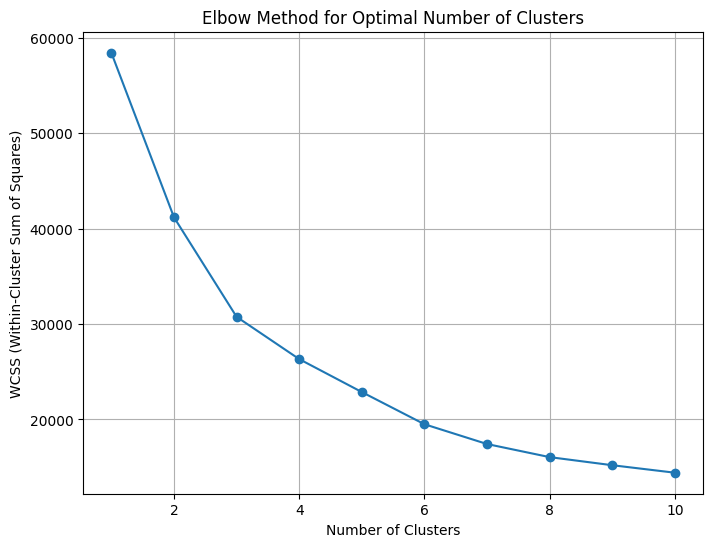

In [37]:
from sklearn.cluster import KMeans
# Initialize an empty list to store WCSS values
wcss = []

# Try different numbers of clusters (from 1 to 10, for example)
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    # kmeans.fit(df_pca)
    kmeans.fit(df_pca)
    wcss.append(kmeans.inertia_)  # inertia_ gives the WCSS value

# Plot the Elbow Method graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()


Elbow method shows slower improvement post 4 clusters. We will choose k=4 for our use case below.

In [61]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Apply K-Means on the PCA data
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(df_pca)

# Add the cluster labels to the PCA DataFrame
df_pca['Cluster'] = kmeans.labels_

# Print cluster centers (optional, to understand how each cluster is defined in PCA space)
print("Cluster Centers:")
print(kmeans.cluster_centers_)

# View first few rows with cluster assignments
print(df_pca.head())


Cluster Centers:
[[-3.58649011e-01  6.88027923e-01  8.78355381e-01  7.77156117e-15]
 [-6.70443733e-01 -9.29978300e-01 -1.58760977e-02  3.00000000e+00]
 [ 1.70764240e-01  6.66073005e-01 -1.16139491e+00  1.00000000e+00]
 [ 1.31862577e+00 -2.52578125e-01 -8.33625657e-02  2.00000000e+00]]
        PC1       PC2       PC3  Cluster
0 -1.590430  1.062728  0.286174        0
1 -0.643978  1.980028 -0.403111        0
2 -0.430627 -0.186858 -1.115781        1
3 -1.405571 -1.103024  0.345548        1
4 -1.494918  0.844712  0.766543        0


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


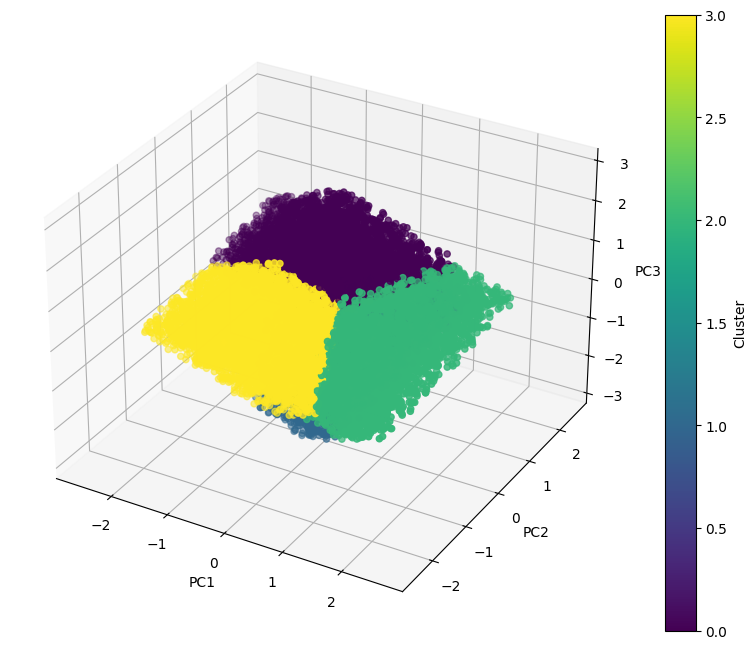

In [46]:
from mpl_toolkits.mplot3d import Axes3D

# Create 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with cluster color
scatter = ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'], c=df_pca['Cluster'], cmap='viridis')

# Add labels and a color bar
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
fig.colorbar(scatter, ax=ax, label='Cluster')
plt.show()


In [47]:
# Calculate the mean values for each cluster
cluster_summary = df_pca.groupby('Cluster').mean()
print(cluster_summary)

              PC1       PC2       PC3
Cluster                              
0       -0.358649  0.688028  0.878355
1        0.170764  0.666073 -1.161395
2        1.318626 -0.252578 -0.083363
3       -0.670444 -0.929978 -0.015876


In [48]:
df_final = df.copy()
df_final['Cluster'] = kmeans.labels_  # Add the cluster labels to the dataframe
cluster_summary_original = df_final.groupby('Cluster')[['Annual Income', 'Spending Score', 'Age']].mean()
print(cluster_summary_original)

         Annual Income  Spending Score       Age
Cluster                                         
0        158986.735952       50.669484 39.481727
1        114064.223140       76.203306 75.519339
2        107580.303818       23.963747 74.760026
3         61065.339767       51.728449 40.103312


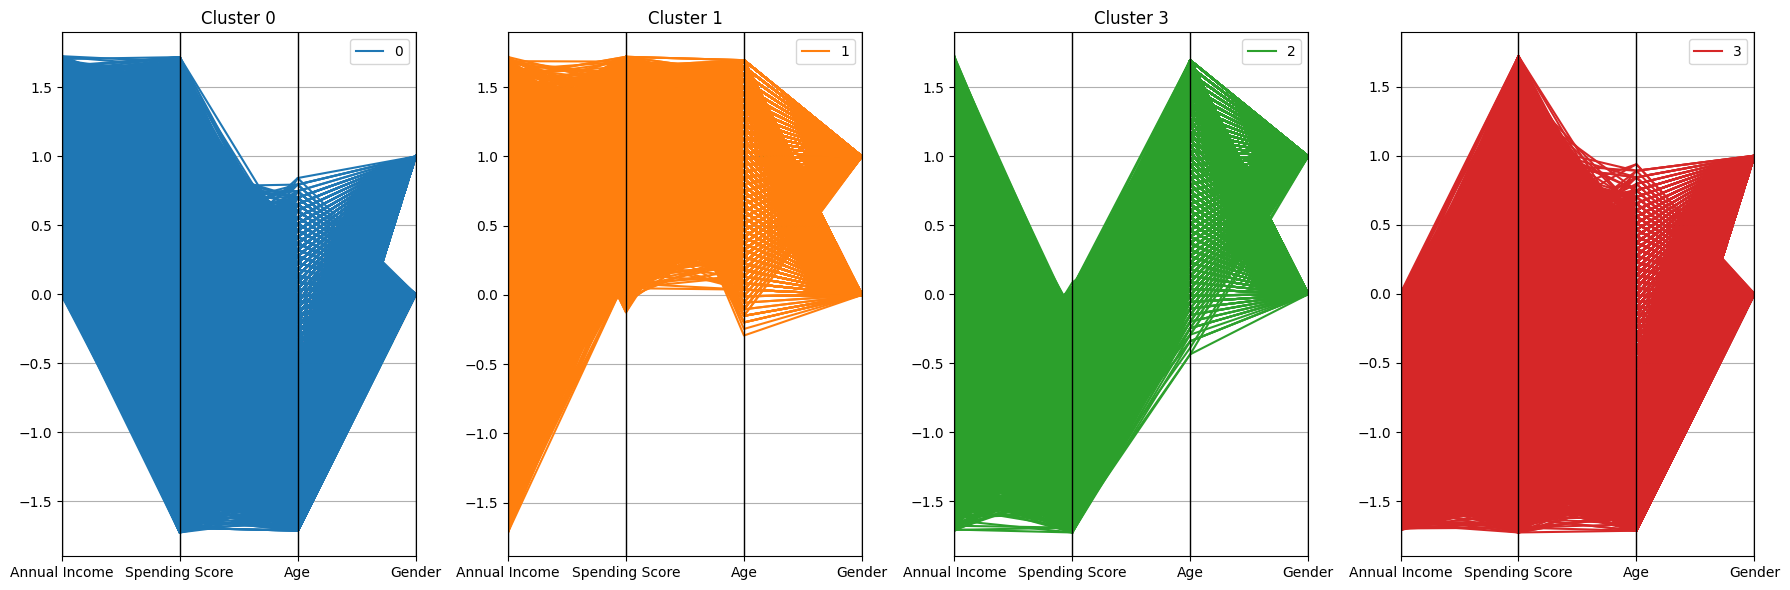

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

def plot_parrallel_plots(df):
    # Assuming you have df_pca with cluster labels added (df_pca['Cluster'] = kmeans.labels_)
    df['Cluster'] = kmeans.labels_
    # 0 - female, 1 - male
    df['Gender'] = LabelEncoder().fit_transform(df['Gender'])
    df_final.head()
    
    # Assuming df is your DataFrame with 'Cluster' column added
    # Filter the data by cluster
    df_cluster_0 = df[df_final['Cluster'] == 0]
    df_cluster_1 = df[df_final['Cluster'] == 1]
    df_cluster_2 = df[df_final['Cluster'] == 2]
    df_cluster_3 = df[df_final['Cluster'] == 3]
    
    # Set up the plotting figure
    fig, axs = plt.subplots(1, 4, figsize=(18, 6))
    
    # Plot parallel coordinates for each cluster
    parallel_coordinates(df_cluster_0, 'Cluster', cols=df_cluster_0.columns[:-1], ax=axs[0], color=plt.cm.tab10(0))
    axs[0].set_title("Cluster 0")
    
    parallel_coordinates(df_cluster_1, 'Cluster', cols=df_cluster_1.columns[:-1], ax=axs[1], color=plt.cm.tab10(1))
    axs[1].set_title("Cluster 1")
    
    parallel_coordinates(df_cluster_2, 'Cluster', cols=df_cluster_2.columns[:-1], ax=axs[2], color=plt.cm.tab10(2))
    axs[2].set_title("Cluster 2")

    parallel_coordinates(df_cluster_3, 'Cluster', cols=df_cluster_3.columns[:-1], ax=axs[3], color=plt.cm.tab10(3))
    axs[2].set_title("Cluster 3")
    
    # Show the plot
    plt.tight_layout()
    plt.show()

plot_parrallel_plots(df_standardized)
# plot_parrallel_plots(df)

# Conclusions

From the plots we can deduce the following
1. Cluster 0 -> This cluster represents high annual income, younger audience. This group has good distribution of spending score. This shows that the rich young audience is divided into 2 groups - one that spends well and others that don't spend. Marketing strategies for encouraging young rich audience can help increase the spending score of such audience.
2. Cluster 1 -> This cluster represents older audience with mostly high annual income. This shows that older audience even if they earn less are spending more. Marketing strategy for this audience is already working great for older audience.
3. Cluster 2 -> This cluster represents older audience with mostly low income. This group is the worst audience for the mall management. These guys have the least spending score. Management can choose to not focus on this group at all or they need major marketing efforts and strategies targeting this group.
4. Cluster 3 -> This cluster represents younger audience with low income. We see that even with low income, there are people in the cluster who spend at mall. This shows they are probably limited by their income to spend, mall management can employ money oriented strategies eg cashbacks, discounts etc. to encourage this group to buy more.
5. We also observe that all clusters have almost equal contribution from both genders, hence there is no need to have gender specific incencentives or marketing campaigns. That would not help business significantly.

Reference:
1. Dataset - https://www.kaggle.com/datasets/datazng/shopping-mall-customer-data-segmentation-analysis/discussion/524147